# Trajectory with STREAM2 for the patient 2
Trajectory done on all the 5 time points
Apply on the cell type subset : T cells, B cells, macrophages, monocytes, NK 

In [1]:
#!pip uninstall stream2 -y
#!pip install git+https://github.com/pinellolab/STREAM2.git
# Restart the kernel
import stream2 as st2
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
#!pip3 install leidenalg

/home/a.blanc-boekholt/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/a.blanc-boekholt/miniconda3/lib/python3.13/site-packages/anndata/__init__.py:70: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
/home/a.blanc-boekholt/miniconda3/lib/python3.13/site-packages/anndata/__init__.py:70: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
/home/a.blanc-boekholt/miniconda3/lib/python3.13/site-packages/anndata/__init__.py:70: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  return modu

In [2]:
adata = sc.read("/home/a.blanc-boekholt/Documents/Singlecell-R/Scripts/Matrix/data_p2.h5ad")

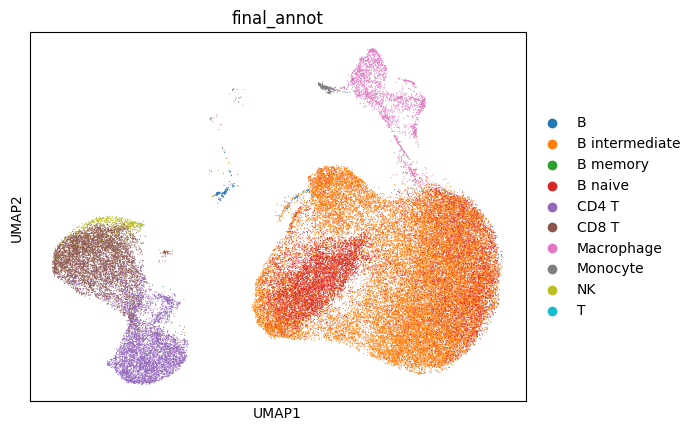

In [3]:
sc.pl.umap(adata,color=['final_annot'])

In [13]:
cell_types_to_keep = [ 'B intermediate', 'B memory', 'B naive', 'Monocyte', 'Macrophage']
adata = adata[adata.obs['final_annot'].isin(cell_types_to_keep)].copy()

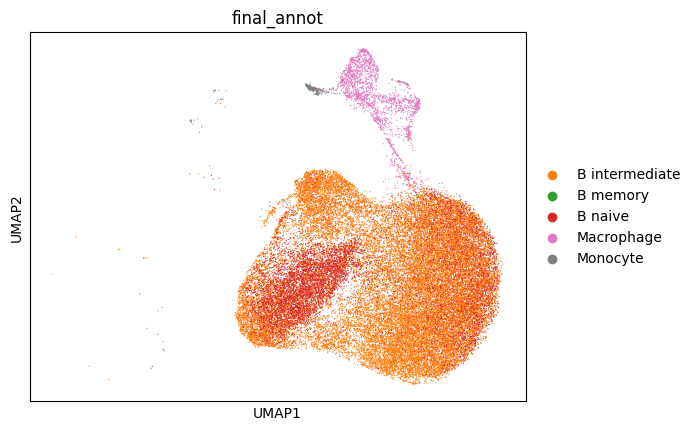

In [14]:
sc.pl.umap(adata,color=['final_annot'])

Found 1 components


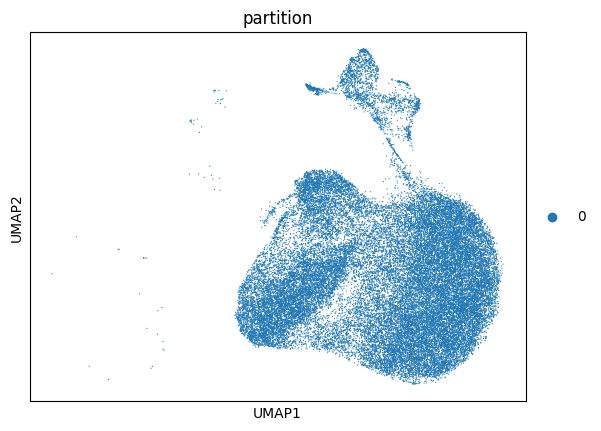

In [20]:
sc.pp.neighbors(adata,use_rep='X_pca')
sc.tl.leiden(adata)
st2.tl.find_disconnected_components(adata,groups='leiden')
sc.pl.umap(adata,color='partition')

<Axes: xlabel='partition'>

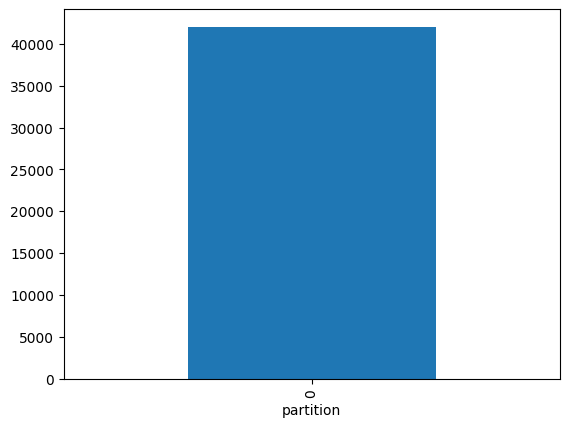

In [21]:
# Many are small clusters which are not adequate for trajectory inference and can be filtered out
# We keep components with more than 500 cells
adata.obs['partition'].value_counts().plot.bar()

Seeding initial graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...


/home/a.blanc-boekholt/miniconda3/lib/python3.13/site-packages/stream2/plotting/_plot.py:940: FutureWarning: Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData.obs_keys, AnnData.obs_keys is deprecated and will be removed in the future.
  if ann in adata.obs_keys():


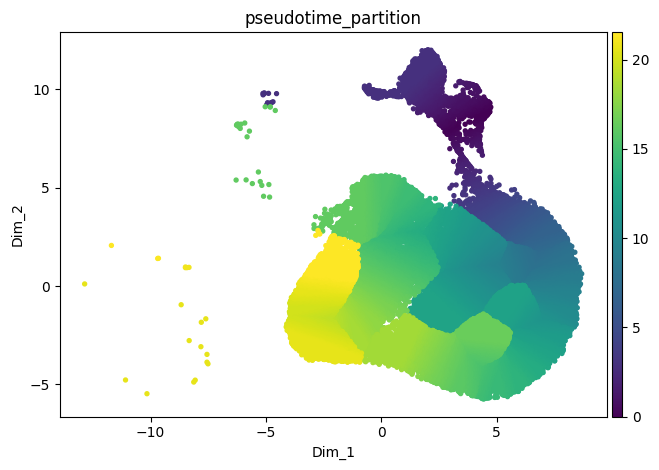

In [18]:
adata.obsm['X_dr'] = adata.obsm['X_umap']
adata.obs['pseudotime_partition'] = np.nan
for part in ['0']:
    cells = adata.obs_names[adata.obs['partition'] == part]
    adata_sub = adata[cells].copy()

    st2.tl.seed_graph(adata_sub, obsm='X_umap', n_clusters=50)

    st2.tl.learn_graph(adata_sub, obsm='X_dr', n_nodes=60, method='principal_tree',)
    
    st2.tl.infer_pseudotime(
        adata_sub,
        source=4,
        key='epg',
        copy=False
    )

    adata.obs.loc[cells, 'pseudotime_partition'] = adata_sub.obs['epg_pseudotime']

adata.obsm['X_dr'] = adata.obsm['X_umap']
st2.pl.dimension_reduction(adata, color=['pseudotime_partition'])
#plt.suptitle("UMAP trajectory by STREAM2, Patient 2", fontsize=16, y=1.02)
#plt.savefig("Plots/p2.png", dpi=300, bbox_inches='tight')

Seeding initial graph for each partition...
Learning elastic principal graph for each partition...


/home/a.blanc-boekholt/miniconda3/lib/python3.13/site-packages/stream2/plotting/_plot.py:1110: FutureWarning: Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData.obs_keys, AnnData.obs_keys is deprecated and will be removed in the future.
  if ann in adata.obs_keys():


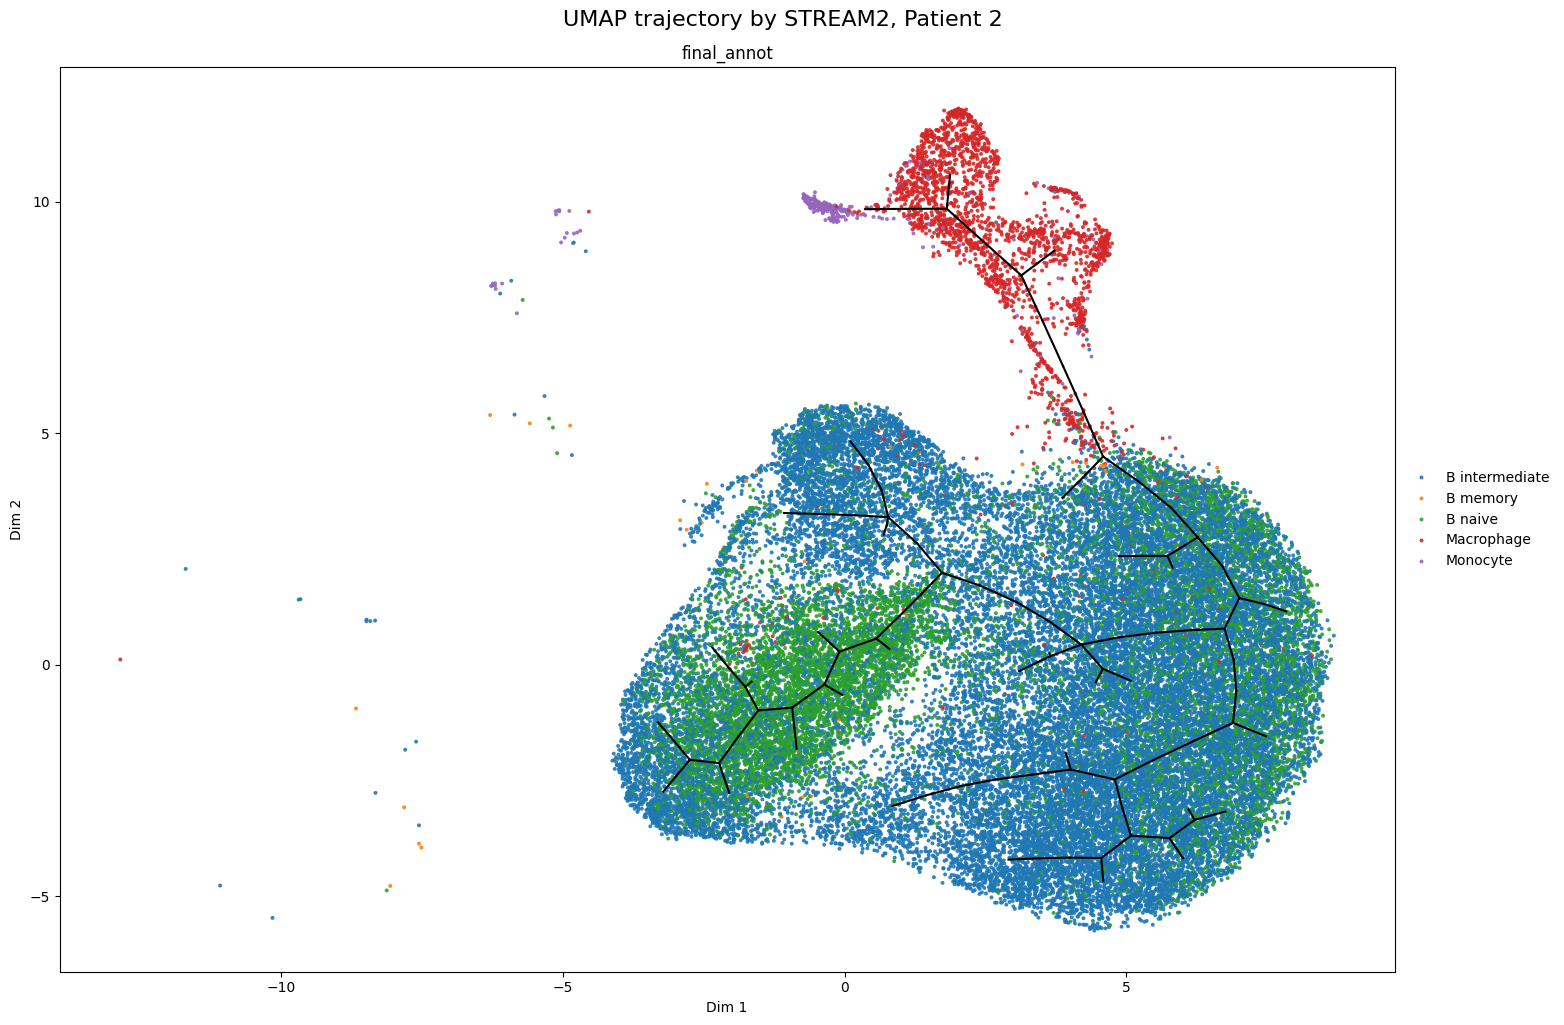

In [35]:
use_partition=['0']
st2.tl.seed_graph(adata, obsm='X_umap', n_clusters=100,use_partition=use_partition)
st2.tl.learn_graph(adata, obsm='X_umap', n_nodes=60,epg_alpha=0.01,epg_mu=0.2,use_partition=use_partition)
st2.pl.graph(adata,key='epg',color=['final_annot'],fig_size=(15,10),save_fig=False)
plt.suptitle("UMAP trajectory by STREAM2, Patient 2", fontsize=16, y=1.02)
plt.savefig("/home/a.blanc-boekholt/Documents/Singlecell-R/Scripts/Plots/graph_p2.png", dpi=300, bbox_inches='tight')
#adata_sub.uns['epg']['leaves']

/home/a.blanc-boekholt/miniconda3/lib/python3.13/site-packages/stream2/plotting/_plot.py:1110: FutureWarning: Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData.obs_keys, AnnData.obs_keys is deprecated and will be removed in the future.
  if ann in adata.obs_keys():


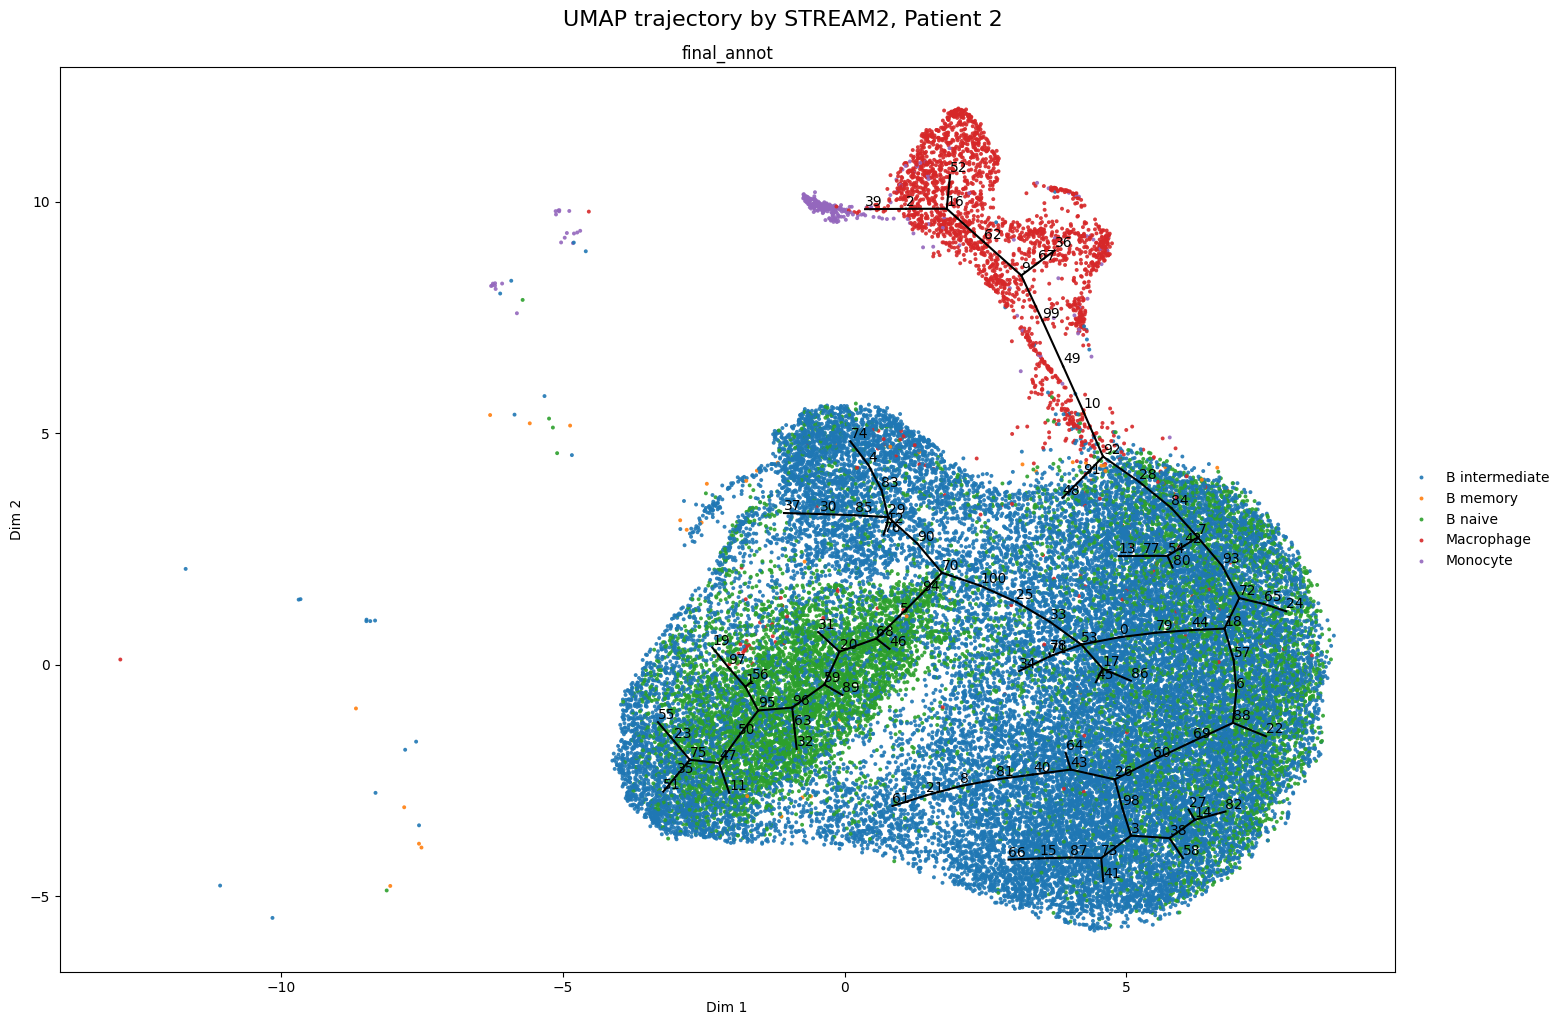

In [32]:
st2.tl._elpigraph._store_graph_attributes(adata,adata.obsm['X_umap'],'epg')
st2.pl.graph(adata,key='epg',color=['final_annot'],show_text=True,fig_size=(15,10),save_fig=False)
plt.suptitle("UMAP trajectory by STREAM2, Patient 2", fontsize=16, y=1.02)
plt.savefig("/home/a.blanc-boekholt/Documents/Singlecell-R/Scripts/Plots/graph_v2_p2.png", dpi=300, bbox_inches='tight')

In [36]:
st2.pl.stream_sc(adata, root='S0', color=['celltype'], show=True)

KeyError: 'node'

In [ ]:
sadata = st2.tl.get_component(adata,'0')
st2.tl._elpigraph._store_graph_attributes(sadata,sadata.obsm['X_umap'],'epg')
st2.pl.graph(sadata,key='epg',color=['final_annot'],show_text=True)

In [ ]:
sadata = st2.tl.get_component(adata,'1')
st2.tl._elpigraph._store_graph_attributes(sadata,sadata.obsm['X_umap'],'epg')
st2.pl.graph(sadata,key='epg',color=['final_annot'],show_node=True)

/home/a.blanc-boekholt/miniconda3/lib/python3.13/site-packages/stream2/plotting/_plot.py:940: FutureWarning: Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData.obs_keys, AnnData.obs_keys is deprecated and will be removed in the future.
  if ann in adata.obs_keys():


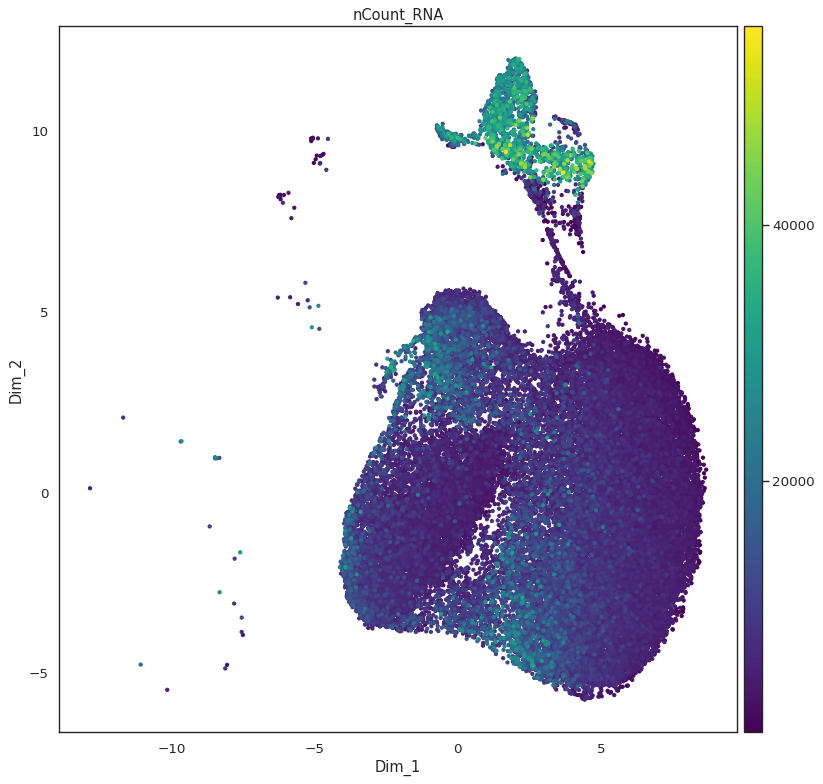

In [37]:
adata.obsm['X_dr'] = adata.obsm['X_umap']
st2.settings.set_figure_params(dpi=80,
                              style='white',
                              fig_size=[5,5],
                              rc={'image.cmap': 'viridis'})

st2.pl.dimension_reduction(adata,color=['nCount_RNA'],
                           fig_legend_ncol=2, fig_size=(10,10))

In [38]:
st2.tl.seed_graph(adata, obsm='X_dr', n_clusters=15)
st2.tl.learn_graph(adata, obsm='X_dr', n_nodes=20, method='principal_tree',)

Seeding initial graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...
Maximum number of iterations ( 10 ) has been reached. diff =  0.09490441017077063


/home/a.blanc-boekholt/miniconda3/lib/python3.13/site-packages/stream2/plotting/_plot.py:1434: FutureWarning: Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData.obs_keys, AnnData.obs_keys is deprecated and will be removed in the future.
  if ann in adata.obs_keys():
/home/a.blanc-boekholt/miniconda3/lib/python3.13/site-packages/stream2/plotting/_utils_stream.py:370: FutureWarning: Use uns (e.g. `k in adata.uns` or `sorted(adata.uns)`) instead of AnnData.uns_keys, AnnData.uns_keys is deprecated and will be removed in the future.
  if 'stream_tree' not in adata.uns_keys():
/home/a.blanc-boekholt/miniconda3/lib/python3.13/site-packages/stream2/plotting/_utils_stream.py:399: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update t

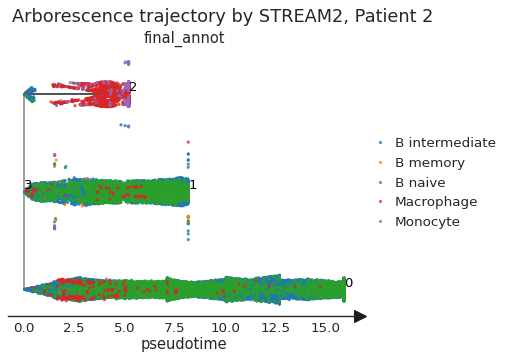

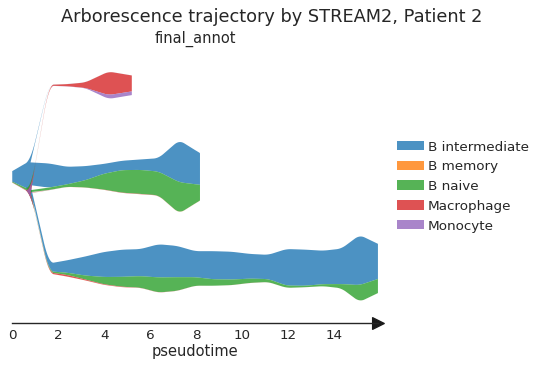

In [45]:
st2.pl.stream_sc(adata, source=3, 
                 dist_scale=0.2, 
                 color=['final_annot'],
                 fig_ncol=2,
                 fig_legend_ncol=1,
                 save_fig=False)
plt.suptitle("Arborescence trajectory by STREAM2, Patient 2", fontsize=16, y=1.02)
plt.savefig("/home/a.blanc-boekholt/Documents/Singlecell-R/Scripts/Plots/p2_arbo_pnt.png", dpi=300, bbox_inches='tight')
st2.pl.stream(adata, source=3, 
                 dist_scale=0.8, 
                 color=['final_annot'],
                 fig_legend_ncol=1)
plt.suptitle("Arborescence trajectory by STREAM2, Patient 2", fontsize=16, y=1.02)
plt.savefig("/home/a.blanc-boekholt/Documents/Singlecell-R/Scripts/Plots/p2_arbo.png", dpi=300, bbox_inches='tight')

In [46]:
st2.pl.stream_sc(adata, source=39, color=['final_annot'], fig_legend_ncol=1,save_fig=False)
st2.pl.stream(adata, source=39, 
              color=['final_annot'],
              fig_legend_ncol=1)
#plt.suptitle("Arborescence trajectory by STREAM2, Patient 2", fontsize=16, y=1.02)
#plt.savefig("Plots/p2_arbobis.png", dpi=300, bbox_inches='tight')
#adata.obsm['X_dr'] = adata.obsm['X_umap']

ValueError: There is no source 39

In [ ]:
st2.tl.infer_pseudotime(adata,source=6, key='epg')
st2.pl.graph(adata,show_text=True,alpha=0.6,color=['epg_pseudotime'])

In [ ]:
adata.obs['pseudotime_partition'] = np.nan
for part in adata.obs['partition'].unique():
    cells = adata.obs_names[adata.obs['partition'] == part]
    adata_sub = adata[cells].copy()

    st2.tl.learn_graph(adata_sub, obsm='X_dr', n_nodes=20, method='principal_tree',)
    
    st2.tl.infer_pseudotime(
        adata_sub,
        source=6,     # ou le root local de cette partition
        key='epg',
        copy=False
    )

    adata.obs.loc[cells, 'pseudotime_partition'] = adata_sub.obs['epg_pseudotime']

st2.pl.graph(adata, color=['pseudotime_partition'])


In [ ]:
adata.obs['partition'].value_counts()

In [ ]:
adata.obs.columns

All the days 

In [ ]:
adata = sc.read("Matrix/data_p2.h5ad")

In [ ]:
sc.pl.umap(adata,color=['final_annot'])

In [ ]:
sc.pp.neighbors(adata,use_rep='X_umap')
sc.tl.leiden(adata)
st2.tl.find_disconnected_components(adata,groups='leiden')
sc.pl.umap(adata,color='partition')

In [ ]:
adata.obs['partition'].value_counts().plot.bar()

In [ ]:
adata.obsm['X_dr'] = adata.obsm['X_umap']
adata.obs['pseudotime_partition'] = np.nan
for part in ['0', '1', '2']:
    cells = adata.obs_names[adata.obs['partition'] == part]
    adata_sub = adata[cells].copy()

    st2.tl.seed_graph(adata_sub, obsm='X_umap', n_clusters=50)

    st2.tl.learn_graph(adata_sub, obsm='X_dr', n_nodes=60, method='principal_tree',)
    
    st2.tl.infer_pseudotime(
        adata_sub,
        source=1,
        key='epg',
        copy=False
    )

    adata.obs.loc[cells, 'pseudotime_partition'] = adata_sub.obs['epg_pseudotime']

adata.obsm['X_dr'] = adata.obsm['X_umap']
st2.pl.dimension_reduction(adata, color=['pseudotime_partition'])
plt.suptitle("UMAP trajectory by STREAM2, Patient 2", fontsize=16, y=1.02)
plt.savefig("Plots/p2.png", dpi=300, bbox_inches='tight')

In [ ]:
st2.tl.seed_graph(adata,obsm='X_umap',use_partition=True)
st2.pl.graph(adata,key='seed_epg',color=['final_annot'])
st2.tl.learn_graph(adata,obsm='X_umap', n_nodes=30,use_partition=True)
st2.pl.graph(adata,key='epg',color=['final_annot'])
st2.pl.graph(adata,key='epg',color=['partition'])
use_partition=['0','1','2']
st2.tl.seed_graph(adata, obsm='X_umap', n_clusters=50,use_partition=use_partition)
st2.tl.learn_graph(adata, obsm='X_umap', n_nodes=60,epg_alpha=0.01,epg_mu=0.05,use_partition=use_partition)
st2.pl.graph(adata,key='seed_epg',color=['partition'])
st2.pl.graph(adata,key='epg',color=['final_annot'],fig_size=(15,10),save_fig=True,fig_path='Plots/',fig_name='stream2_p2.pdf')

In [ ]:
cell_types_to_keep = ['Macrophage', 'Monocyte', 'B', 'B intermediate', 'B memory', 'B naive']
adata_subset = adata[adata.obs['final_annot'].isin(cell_types_to_keep)].copy()
st2.tl.seed_graph(adata_subset, obsm='X_umap', n_clusters=50)
st2.tl.learn_graph(adata_subset, obsm='X_umap', n_nodes=60,epg_alpha=0.01,epg_mu=0.05)
st2.pl.stream_sc(adata_subset, source=1, color=['final_annot'], fig_legend_ncol=1,save_fig=False,show_text=True)
plt.suptitle("Arborescence trajectory on B cells, monocytes and macrophages\n by STREAM2, Patient 2", fontsize=16, y=1.12)
plt.savefig("Plots/p2_arbobis.png", dpi=300, bbox_inches='tight')
st2.pl.stream(adata_subset, source=1, 
              color=['final_annot'],
              fig_legend_ncol=1)
plt.suptitle("Arborescence trajectory on B cells, monocytes and macrophages\n by STREAM2, Patient 2", fontsize=16, y=1.12)
plt.savefig("Plots/p2_arbostream.png", dpi=300, bbox_inches='tight')